### Project Aurelius

As the last Emperor of the Pax Romana, the age of peace and stability in the Roman Empire, Marcus Aurelius would be happy to know I'm now using his name for a project to detect abrupt or anomalous changes in time series signals.

## Background

A Varational Long Short Term Memory (LSTM) Autoencoder (src/model.py) was built using PyTorch. An Autoencoder is made of two models, an Encoder and a Decoder. The Encoder accepts a fixed length time series signal, and passes the signal through LSTM cells. The result is a vector representing the signal's temporal relationships. The *varational* in a Varational Autoencoder means there is one extra step: the vector is broken down further into its **mean** and **variance** vectors. The Decoder is just the reverse of the Encoder, its job is to use the mean and variance of the vector and reconstruct the original signal.

# The Goal

The model was trained on 10,000 random samples of the function sin(f\*x + p) where the phase p is 0 < p < 2 \* pi, and the frequency f is 0 < f < 0.1. After training, if we pass in more samples from our sin function within our frequency limit we should expect a low reconstruction error. If change the signal, e.g., we increase the frequency to past our limit of 0.1, we should see a higher error. Lets prove this works on a simple sin(x) first, then we can move to more complex functions.

## Why
A heat exchanger is a system to transfer heat between two fluids. Online monitoring of commercial heat exchangers is done by tracking the overall heat transfer coefficient. Fouling, caused by the build-up of impurities in the heat exhanger, increases the resistance to heat transfer, thereby decreasing the overall heat transfer coefficient. But some studies have shown that fouling can actually increase the heat transfer coefficient for a short period of time thanks to greater roughness on the heat transfer surface. Either way, fouling definitely causes the heat transfer coefficient to act abnormally, which is what we want. A simple way to detect fouling is if the heat transfer coefficient dips below a threshold. More interestingly, can the autoencoder detect a pattern change caused by the impurity build-up far before the threshold is broken. If yes, then the Autoencoder method can save owner operators money in maintenance costs thanks to early detection of fouling. 

In [4]:
# import our libraries
import os
PATH = '/home/johnny/git/aurelius'
os.chdir(PATH)

from src.model import VarationalAutoencoder
import torch

In [5]:
# copy our training parameters and load in the model
TIMESTEPS = 100
ENCODING_DIM = 7
HIDDEN_DIM = 64
LATENT_SIZE = 7
device = torch.device('cpu')

model = VarationalAutoencoder(TIMESTEPS, ENCODING_DIM, LATENT_SIZE, [HIDDEN_DIM])
model.to(device)
model.load_state_dict(torch.load('./checkpoint.pt'))
model.eval()

VarationalAutoencoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): LSTM(100, 64, batch_first=True)
      (1): LSTM(64, 7, batch_first=True)
    )
    (h_activ): Sigmoid()
    (out_activ): Tanh()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): LSTM(7, 64, batch_first=True)
      (1): LSTM(64, 64, batch_first=True)
    )
    (h_activ): Sigmoid()
  )
  (encoding_to_mu): Linear(in_features=7, out_features=7, bias=True)
  (encoding_to_var): Linear(in_features=7, out_features=7, bias=True)
  (latent_to_encoding): Linear(in_features=7, out_features=7, bias=True)
)

In [7]:
 # lets make a function to compare our two sin(x) signals
from src.utils import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
def compare(freq, phase, title=''):
    sine = [(np.sin(freq * j + phase) + 1)*0.5 for j in range(TIMESTEPS)]
    tensor_sine = torch.tensor(sine).unsqueeze(0).float()
    out = model(tensor_sine).squeeze().data
    plt.plot(sine, label='original signal')
    plt.plot(out, label='model output')
    plt.legend()
    plt.title(title)
    plt.show()

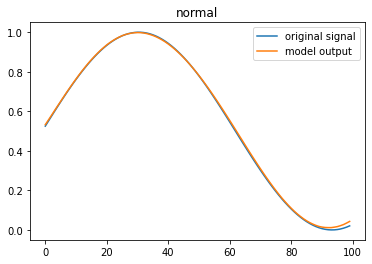

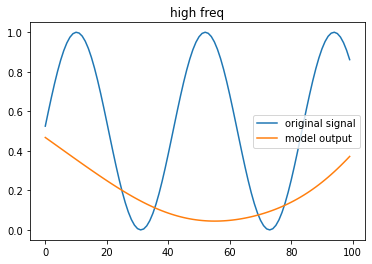

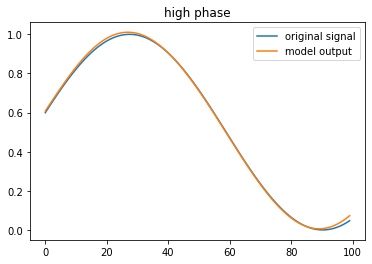

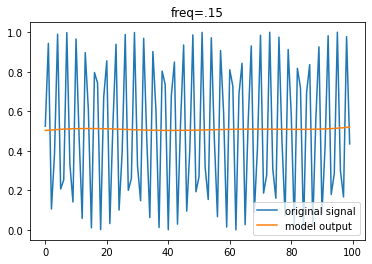

In [9]:
# freq was trained between 0 and .1
# phase was trained between 0 and 2 pi
compare(freq = 0.05, phase=0.05, title='normal')
compare(freq = 0.15, phase=0.05, title='high freq')
compare(freq = 0.05, phase=0.2, title='high phase')
compare(freq = 2, phase=0.05, title='freq=.15')

You can see from the plots above that signals with a higher frequency than our frequency bound of 0.1 cannot be accurately reconstructed. How about mean shifts?  

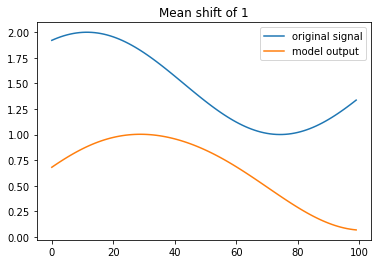

In [10]:
MEAN_SHIFT = 1
TITLE = 'Mean shift of 1'
freq = 0.05
phase = 1
sine = [((np.sin(freq * j + phase) + 1)*0.5) + MEAN_SHIFT for j in range(TIMESTEPS)]
tensor_sine = torch.tensor(sine).unsqueeze(0).float()
out = model(tensor_sine).squeeze().data
plt.plot(sine, label='original signal')
plt.plot(out, label='model output')
plt.legend()
plt.title(TITLE)
plt.show()

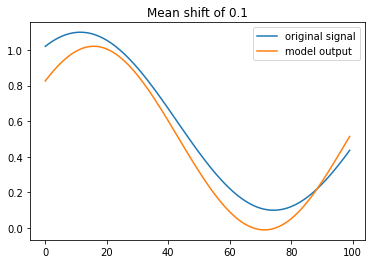

In [12]:
MEAN_SHIFT = 0.1
TITLE = 'Mean shift of 0.1'
freq = 0.05
phase = 1
sine = [((np.sin(freq * j + phase) + 1)*0.5) + MEAN_SHIFT for j in range(TIMESTEPS)]
tensor_sine = torch.tensor(sine).unsqueeze(0).float()
out = model(tensor_sine).squeeze().data
plt.plot(sine, label='original signal')
plt.plot(out, label='model output')
plt.legend()
plt.title(TITLE)
plt.show()

Nice. The larger the mean shift, the worse the model is at reconstructing a perfect copy. how about spikes?

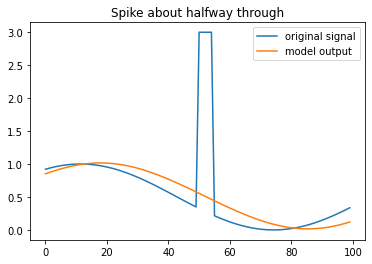

In [15]:
SPIKE_VALUE = 3
SPIKE_POS = range(TIMESTEPS // 2, (TIMESTEPS // 2) + 5)
TITLE = 'Spike about halfway through'
freq = 0.05
phase = 1
sine = [(np.sin(freq * j + phase) + 1)*0.5 for j in range(TIMESTEPS)]
sine = [SPIKE_VALUE if idx in SPIKE_POS else x for idx, x in enumerate(sine)]
tensor_sine = torch.tensor(sine).unsqueeze(0).float()
out = model(tensor_sine).squeeze().data
plt.plot(sine, label='original signal')
plt.plot(out, label='model output')
plt.legend()
plt.title(TITLE)
plt.show()

Works again! Our model has no idea what to do and just keeps producing a normal signal. The reconstruction error is high where the spike is.

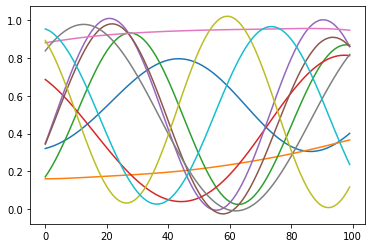

In [22]:
# sample from the autoencoder at random
samples = [model.sample() for i in range(10)]
for sample in samples:
    plt.plot(sample.squeeze().data)

plt.show()

## now try with a heat exchanger model